EI Bump Attractor Network Model
===============================



## notebook settings



In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

%run ../notebooks/setup.py
%matplotlib inline
%config InlineBackend.figure_format = 'png'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python exe
/home/leon/mambaforge/envs/dual_data/bin/python

## EI Balanced Attractor Model



Here I implemented a balanced EI network that exhibits attractor dynamics.



### imports



In [1]:
import sys
sys.path.insert(0, '/home/leon/tmp/rnn_numba') # put here the path to the repo
from src.model.rate_model import Network

### Single trial



#### Simulation



To run a simulation, first we need to define a network model.
The class Network takes three mandatory arguments:

1.  The name of the configuration file that defines the model,
    eg 'config<sub>EI.yml</sub>', these files are in ../conf/ and well detailed.

2.  The name of the output file that will contain the simulation data.
    eg 'bump'. Simulation results will be saved as a data frame to '../data/simul/bump.h5'.

3.  The path to the root of this repository.

One can also pass extra arguments to Network, basically any parameter that is in the config file so that it will be overwritten.



In [1]:
REPO_ROOT = "/home/leon/tmp/rnn_numba"
model = Network('config_EI.yml', 'bump', REPO_ROOT, VERBOSE=1)

Loading config from /home/leon/tmp/rnn_numba/conf/config_EI.yml
Saving data to /home/leon/tmp/rnn_numba/data/simul/bump.h5
Jab [[ 1.  -1.5]
 [ 1.  -1. ]]
Tuning, KAPPA [5. 0. 0. 0.]
Asymmetry, SIGMA [0. 0. 0. 0.]
Iext [0.5  0.25]

Then one just runs the model with



In [1]:
model.run()

#+begin_example
  Generating matrix Cij
  sparse connectivity
  with spec cosine structure
  sparse connectivity
  sparse connectivity
  sparse connectivity
  Saving matrix to /home/leon/tmp/rnn_numba/data/matrix/Cij.npy
  Parameters:
  N 10000 Na [7500 2500] K 500.0 Ka [500. 500.]
  Iext [11.18033989  5.59016994] Jab [ 0.04472136 -0.06708204  0.04472136 -0.04472136]
  Tuning, KAPPA [5. 0. 0. 0.]
  Asymmetry, SIGMA [0. 0. 0. 0.]
  MF Rates: [0.25 0.5 ]
  Transfert Func Sigmoid
  Running simulation
  times (s) 0.25 rates (Hz) [0.03, 0.12]
  times (s) 0.5 rates (Hz) [0.03, 0.12]
  times (s) 0.75 rates (Hz) [0.03, 0.11]
  times (s) 1.0 rates (Hz) [0.03, 0.12]
  STIM ON
  times (s) 1.25 rates (Hz) [0.53, 0.74]
  times (s) 1.5 rates (Hz) [0.53, 0.74]
  STIM OFF
  times (s) 1.75 rates (Hz) [0.36, 0.6]
  times (s) 2.0 rates (Hz) [0.36, 0.6]
  times (s) 2.25 rates (Hz) [0.36, 0.6]
  times (s) 2.5 rates (Hz) [0.36, 0.6]
  times (s) 2.75 rates (Hz) [0.36, 0.6]
  times (s) 3.0 rates (Hz) [0.36, 0

#### Analysis



##### Imports



In [1]:
import pandas as pd
from src.analysis.decode import decode_bump

##### Load data



In [1]:
df = pd.read_hdf(REPO_ROOT + "/data/simul/bump.h5", mode="r")
df_E = df[df.neurons<7500]
df_I = df[df.neurons>=7500]

print(df.head())

rates        ff       h_E       h_I  neurons   time
0  0.016484  0.516858  0.660207 -4.258005        0  0.249
1  0.010508  0.068475  0.606468 -4.101016        1  0.249
2  0.039072  0.148301  0.625659 -3.540477        2  0.249
3  0.033662  1.185190  0.600276 -3.787884        3  0.249
4  0.044454 -0.488017  0.634493 -3.749277        4  0.249

##### Rates



###### raster



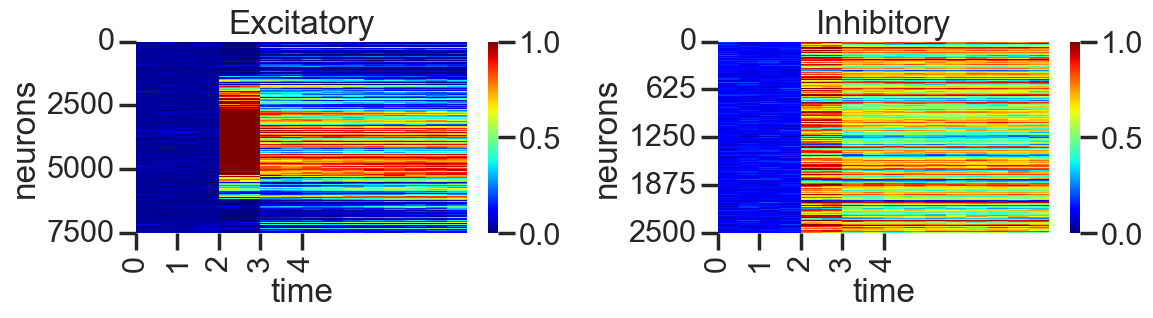

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])
pt = pd.pivot_table(df, values="rates", index=["neurons"], columns="time")

sns.heatmap(pt[:7500], cmap="jet", ax=ax[0], vmax=1, vmin=0)
ax[0].set_yticks([0, 2500, 5000, 7500], [0, 2500, 5000, 7500])
ax[0].set_xticks([0, 2, 4, 6, 8], [0, 1, 2, 3, 4])
ax[0].set_title('Excitatory')

sns.heatmap(pt[7500:], cmap="jet", ax=ax[1], vmax=1, vmin=0)
ax[1].set_yticks([0, 625, 1250, 1875, 2500], [0, 625, 1250, 1875, 2500])
ax[1].set_xticks([0, 2, 4, 6, 8], [0, 1, 2, 3, 4])
ax[1].set_title('Inhibitory')

plt.show()

###### histograms



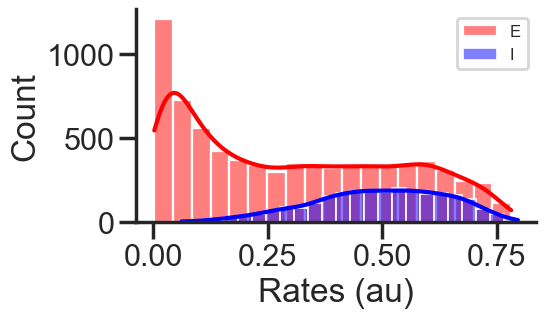

In [1]:
mean_df_E = df_E.groupby("neurons").mean()
mean_df_E[mean_df_E.rates<.001] = np.nan

mean_df_I = df_I.groupby("neurons").mean()
mean_df_I[mean_df_I.rates<.001] = np.nan

sns.histplot(mean_df_E, x=mean_df_E.rates, kde=True, color='r', label='E')
sns.histplot(mean_df_I, x=mean_df_I.rates, kde=True, color='b', label='I')
plt.legend(fontsize=12)
plt.xlabel("Rates (au)")
plt.show()

##### Tuning



In [1]:
data = df_E.groupby(['time'])['rates'].apply(decode_bump).reset_index()
data[['m0', 'm1', 'phase']] = pd.DataFrame(data['rates'].tolist(), index=data.index)
data = data.drop(columns=['rates'])

print(data.head())

time        m0        m1     phase
0  0.249  0.026883  0.000102  6.019133
1  0.499  0.026896  0.000113  3.882348
2  0.749  0.026606  0.000504  0.829742
3  0.999  0.027251  0.000305  2.127723
4  1.249  0.534482  0.597531  3.139320

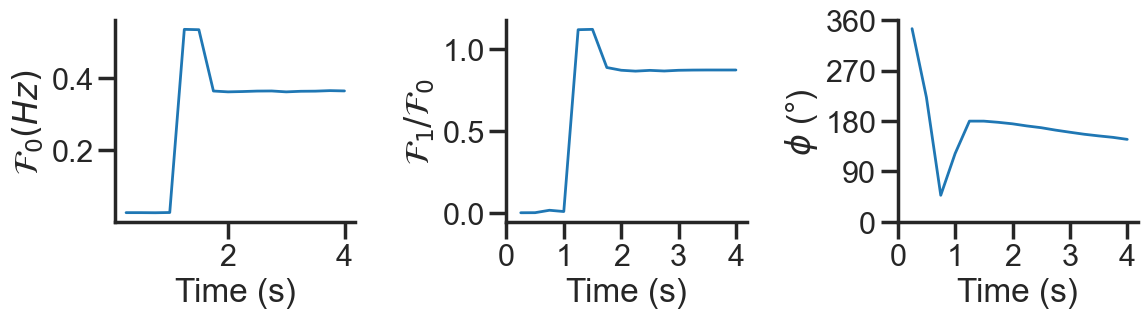

In [1]:
fig, ax = plt.subplots(1, 3, figsize=[2*width, height])

sns.lineplot(data=data, x='time', y='m0', legend=False, lw=2, ax=ax[0])
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('$\mathcal{F}_0 (Hz)$')
ax[1].set_xticks([0, 1, 2, 3, 4])

sns.lineplot(x=data['time'], y=data['m1']/data['m0'], legend=False, lw=2, ax=ax[1])
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('$\mathcal{F}_1 / \mathcal{F}_0$')
ax[1].set_xticks([0, 1, 2, 3, 4])

sns.lineplot(x=data['time'], y=data['phase']*180/np.pi, legend=False, lw=2, ax=ax[2])
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('$\phi$ (°)')
ax[2].set_xticks([0, 1, 2, 3, 4])
ax[2].set_yticks([0, 90, 180, 270, 360])
plt.show()